In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

# to glob files
import glob
# to import / resize images
import cv2 # Open CV 3.1, on Mac OS brew install opencv

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# to print classification stats in a nice format
from sklearn.metrics import classification_report

# for dynamic graph rendering
from IPython import display

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 13]

In [71]:
# DATA FROM: http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
image_dir = '101_ObjectCategories'

In [72]:
class_names = ['airplanes', 'Faces', 'Leopards', 'Motorbikes']

In [73]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [74]:
class Swish(nn.Module):
    def forward(self, x):
        return x * nn.Sigmoid(x)

In [75]:
width = 320
height = 200
depth = 3

# model
model = nn.Sequential(
    # input 3x96x96, output 16 channels, 45x45
    nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=0),
    # input 16x45x45 output 32x45x45
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    # input 32x45x45 output 32x23x23
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Dropout2d(p=0.25),

    # input 32x23x23 output 32x23x23
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    # input 32x23x23 output 64x12x12
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    
    nn.Dropout2d(p=0.25),

    # input 64x12x12 output 128x12x12
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    # input 128x12x12 output 128x6x6
    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    
    nn.Dropout2d(p=0.25),

    Flatten(),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 4),
    nn.Softmax(dim=1),
)
    

In [76]:
data = []
labels = []

In [77]:
files = glob.glob(image_dir+'/*/*.jpg')

In [78]:
for file in files:
    label = file.split("/")[-2]
    if label not in class_names:
        continue
    img = cv2.imread(file)
    img_t = cv2.resize(img, (96, 96))
    data.append(img_t)
    labels.append(label)

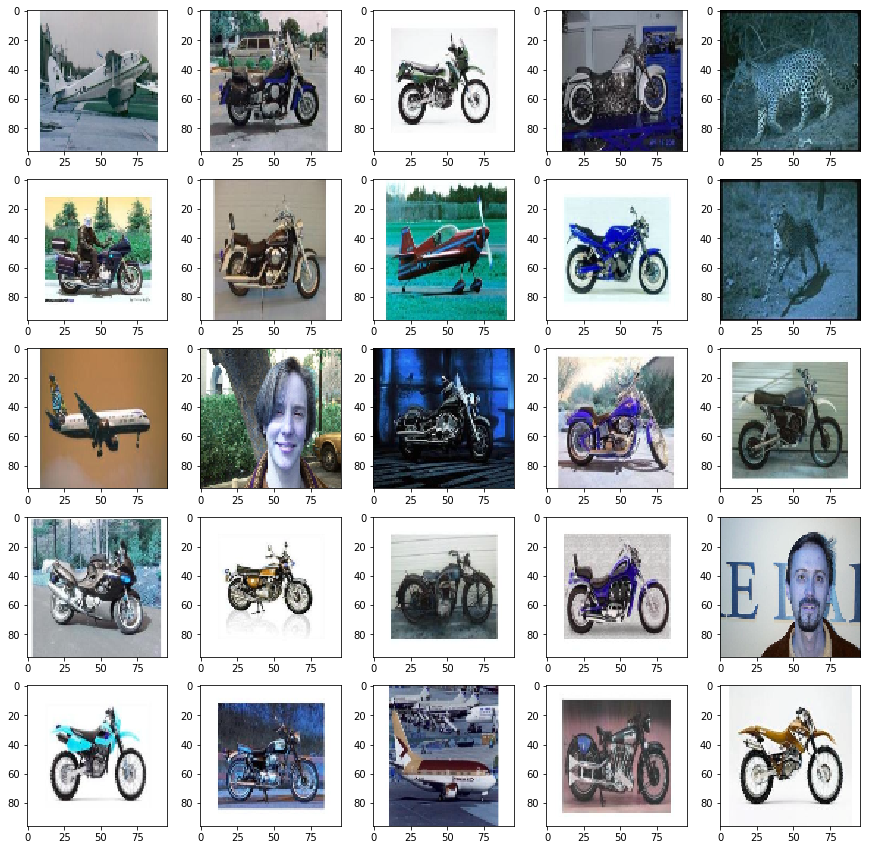

In [79]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(data[np.random.randint(0, len(data))])

### Note: colors are off because we're using a different color space, but it doesn't really matter here.

In [80]:
# LabelBinarizer is used to 
lb = LabelBinarizer()
labelsb = lb.fit_transform(labels)
lb.classes_

array(['Faces', 'Leopards', 'Motorbikes', 'airplanes'], dtype='<U10')

In [81]:
print(len(labels))
print(labelsb[0])
print(labels[0])

2233
[0 0 0 1]
airplanes


In [82]:
# scale all our data (images encoded in RGB 24 bits -> [0-255] per pixel) to [0, 1]
data = np.array(data, dtype=float) / 255.0

In [83]:
# reshape to what PyTorch expects, i.e. batch first, then channels (colors), width, height
data = data.reshape(data.shape[0], 3, 96, 96)

In [84]:
data.shape

(2233, 3, 96, 96)

In [85]:
# split training and testign sets
(trainX, testX, trainY, testY) = train_test_split(data, labelsb, test_size=0.25, stratify=labelsb, random_state=42)

In [86]:
# convert to torch Tensors to feed to the network
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [87]:
# define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [88]:
def train():
    optimizer.zero_grad()
    output = model(trainX)
    loss = loss_fn(output, trainY)
    loss.backward()
    optimizer.step()
#     print(loss.item())
    return loss.item()

In [89]:
losses = []
step = 0

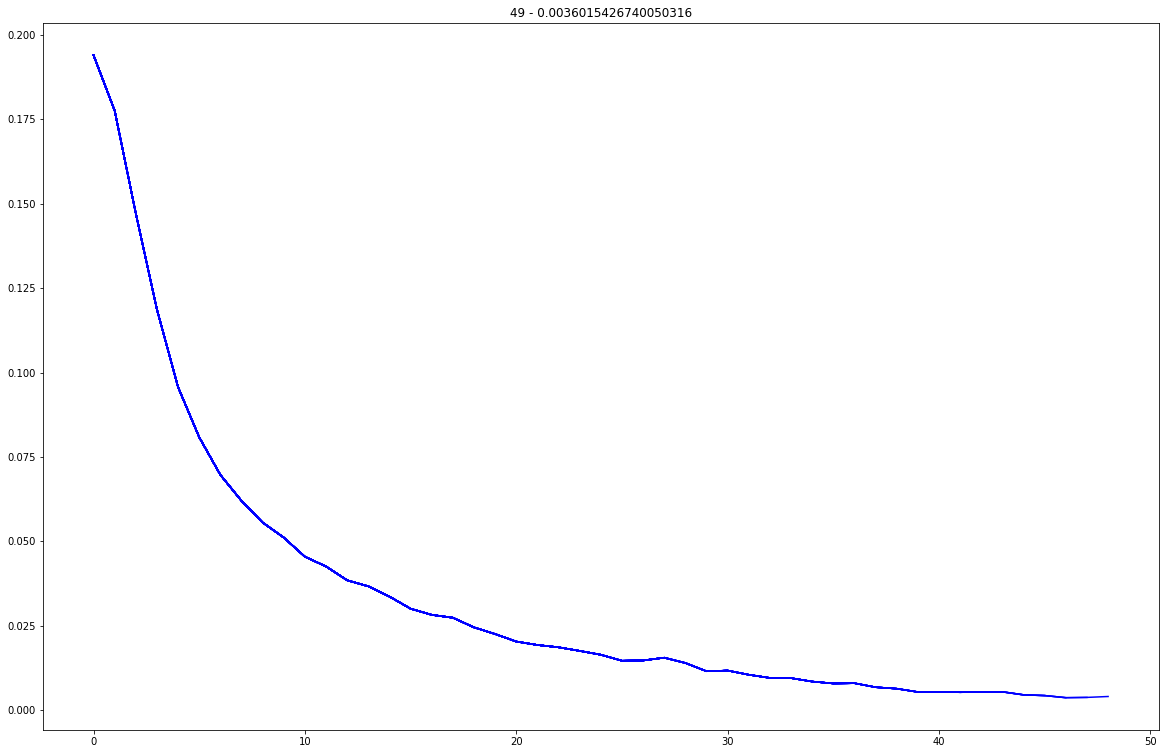

In [90]:

fig = plt.figure(1)
ax = fig.add_subplot(111)
fig.show()

while step < 50:
    loss = train()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    ax.plot(losses, 'b-')
    ax.set_title("{} - {}".format(step, loss))
    losses.append(loss)
    step += 1

In [91]:
# plt.imshow(testX[1].reshape(96,96,3))

In [92]:
torch.save(model.state_dict(), 'Stridenet.pth')

In [93]:
model.load_state_dict(torch.load('Stridenet.pth'))
model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout2d(p=0.25)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): ReLU()
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout2d(p=0.25)
  (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [94]:
predictions = model(testX)

In [95]:
predictions[0]

tensor([0.0062, 0.9587, 0.0330, 0.0021], grad_fn=<SelectBackward>)

In [96]:
testY[0]

tensor([0., 1., 0., 0.])

In [97]:
# Classification_report prints a nice output of the performances of our model

# detach().numpy() is necessary to detach the Tensor data and conver to numpy array
# argmax gives us the highest probability for each 
print(classification_report(testY.detach().numpy().argmax(axis=1),  
                            predictions.detach().numpy().argmax(axis=1),
                            target_names=lb.classes_))

              precision    recall  f1-score   support

       Faces       0.99      0.96      0.98       109
    Leopards       1.00      1.00      1.00        50
  Motorbikes       0.96      0.94      0.95       200
   airplanes       0.95      0.98      0.97       200

   micro avg       0.97      0.97      0.97       559
   macro avg       0.98      0.97      0.97       559
weighted avg       0.97      0.97      0.97       559

